# Investigate spatial outliers

We take a look at all structures that contain residues (CA atoms) with a distance to the `kissim` subpocket centers below/above a certain minimum/maximum cutoff. 

This allows us to identify outlier structures that we want to exclude from our dataset (in our `kissim` pipeline this is done with the `kissim outlier` CLI).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

# from opencadd.structure.pocket import PocketKlifs, PocketViewer
from opencadd.databases.klifs import setup_remote
from kissim.encoding import FingerprintGenerator

from src.paths import PATH_RESULTS

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = PATH_RESULTS / "all"

In [5]:
REMOTE = setup_remote()

## Set distance minimum/maximum cutoffs

These cutoffs define spatial outliers.

In [6]:
DISTANCE_CUTOFFS = {
    "hinge_region": (1, 34),
    "dfg_region": (1, 34),
    "front_pocket": (1, 34),
    "center": (1, 34),
}
print(
    f"Use the following distance minimum/maximum cutoffs"
    f" to identify outlier structures: {DISTANCE_CUTOFFS}"
)

Use the following distance minimum/maximum cutoffs to identify outlier structures: {'hinge_region': (1, 34), 'dfg_region': (1, 34), 'front_pocket': (1, 34), 'center': (1, 34)}


## Load fingerprints

Let's load our pre-calculated fingerprint saved in a _json_ file as `FingerprintGenerator` object.

In [7]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_normalized.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")

Number of fingerprints: 4681


## Get distance features

Lets load distances (from each residue to each subpocket center) for all fingerprints.

In [8]:
distances = fingerprint_generator.distances_exploded
distances

hinge_region  dfg_region  front_pocket  \
structure_klifs_id residue_ix                                           
1                  1               0.159825    0.145453      0.286681   
                   2               0.285878    0.135771      0.398850   
                   3               0.252358    0.180912      0.278772   
                   4               0.353124    0.381143      0.261598   
                   5               0.518188    0.273464      0.443723   
...                                     ...         ...           ...   
13864              81              0.489783    0.172027      0.573236   
                   82              0.695578    0.586294      0.839066   
                   83              0.373596    0.296954      0.679086   
                   84              0.482725    0.361340      0.680946   
                   85              0.683409    0.527817      0.882152   

                                 center  
structure_klifs_id residue_ix            
1                  1           0.192528  
                   2           0.328810  
                   3           0.289715  
                   4           0.323429  
                   5           0.487763  
...                                 ...  
13864              81          0.511184  
                   82          0.669919  
                   83          0.390541  
                   84          0.381279  
                   85          0.613500  

[397885 rows x 4 columns]

In [9]:
distances.describe()

,hinge_region,dfg_region,front_pocket,center
count,392931.000000,390473.000000,392931.000000,392931.000000
mean,0.416334,0.403289,0.418873,0.409977
std,0.174473,0.155223,0.165562,0.173825
min,0.000000,0.000000,0.000000,0.000000
25%,0.283579,0.287482,0.292781,0.281612
50%,0.407828,0.402325,0.406613,0.384467
75%,0.539430,0.511687,0.528786,0.527649
max,1.000000,1.000000,1.000000,1.000000


## Get structures with extreme distances

Let's plot distance histograms (over all residue positions) per subpocket center and retain only extreme distances.

In [10]:
def extreme_distances(distances, feature_type, distance_cutoffs):

    cutoff_min = distance_cutoffs[feature_type][0]
    cutoff_max = distance_cutoffs[feature_type][1]

    features = distances[feature_type]
    range_full = round(features.max() - features.min(), 2)
    features_min = features[features < cutoff_min]
    features_max = features[features > cutoff_max]
    range_min_max = cutoff_max - cutoff_min
    n_structures_below_min = len(features_min.reset_index()["structure_klifs_id"].unique())
    n_structures_above_max = len(features_max.reset_index()["structure_klifs_id"].unique())
    n_residues_below_min = len(features_min.reset_index()["residue_ix"].unique())
    n_residues_above_max = len(features_max.reset_index()["residue_ix"].unique())
    range_below_min = round(features_min.max() - features_min.min(), 2)
    range_above_max = round(features_max.max() - features_max.min(), 2)

    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
    fig.suptitle(f"Extreme distances seen in subpocket {feature_type}", fontsize="x-large")
    axes[0].axvspan(cutoff_min, cutoff_max, color="cyan", alpha=0.1)
    features.plot(
        kind="hist",
        bins=100,
        ax=axes[0],
        title=f"All structures (full range {range_full} A, cutoff range {range_min_max} A / cyan)",
    )
    features_min.plot(
        kind="hist",
        ax=axes[1],
        title=f"Below {cutoff_min} A: #{n_structures_below_min} structures |"
        f" #{n_residues_below_min} residue positions (range {range_below_min} A)",
    )
    features_max.plot(
        kind="hist",
        ax=axes[2],
        title=f"Above {cutoff_max} A: #{n_structures_above_max} structures |"
        f" #{n_residues_above_max} residue positions (range {range_above_max} A)",
    )

    return features_min, features_max

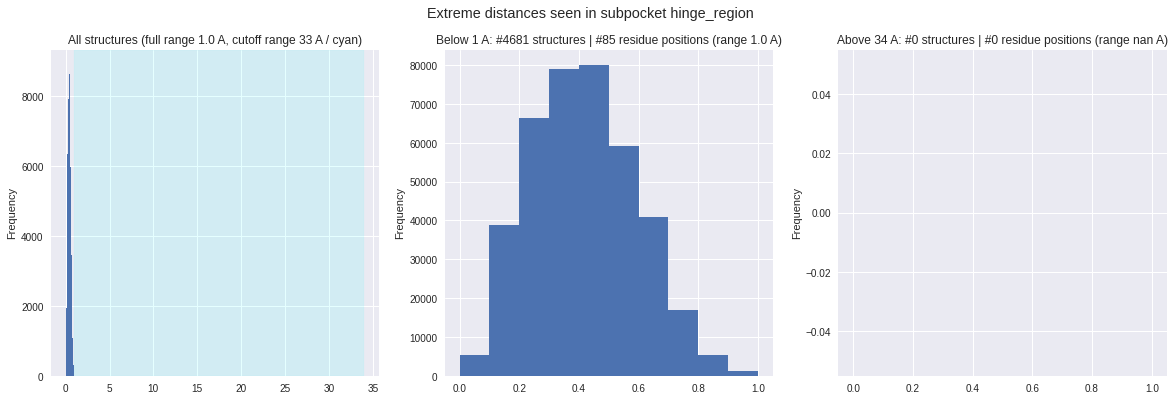

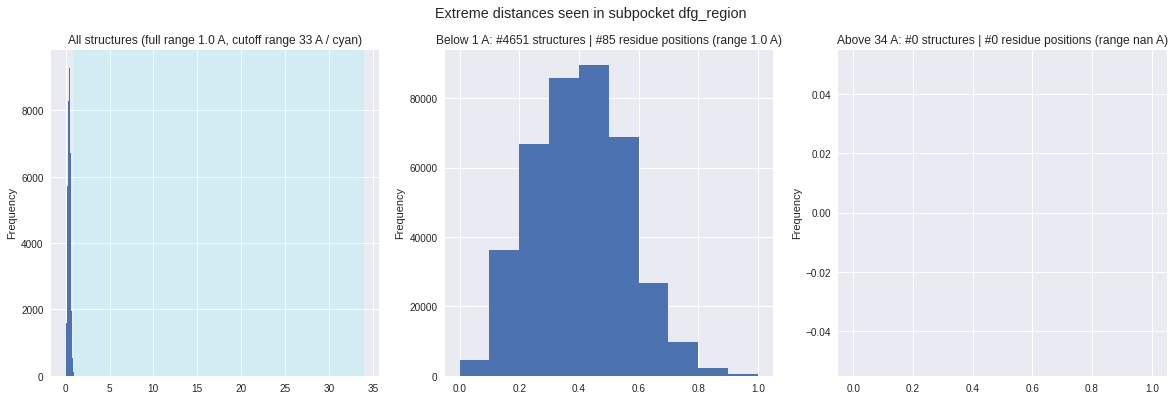

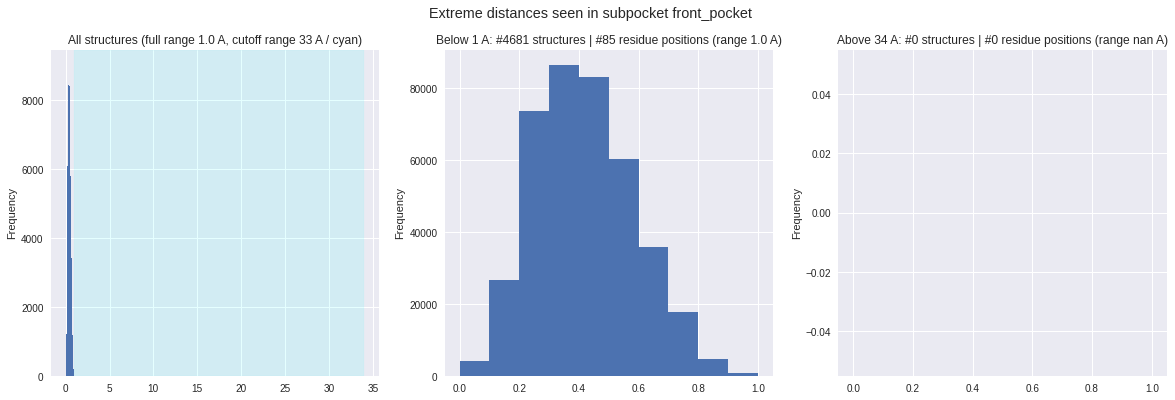

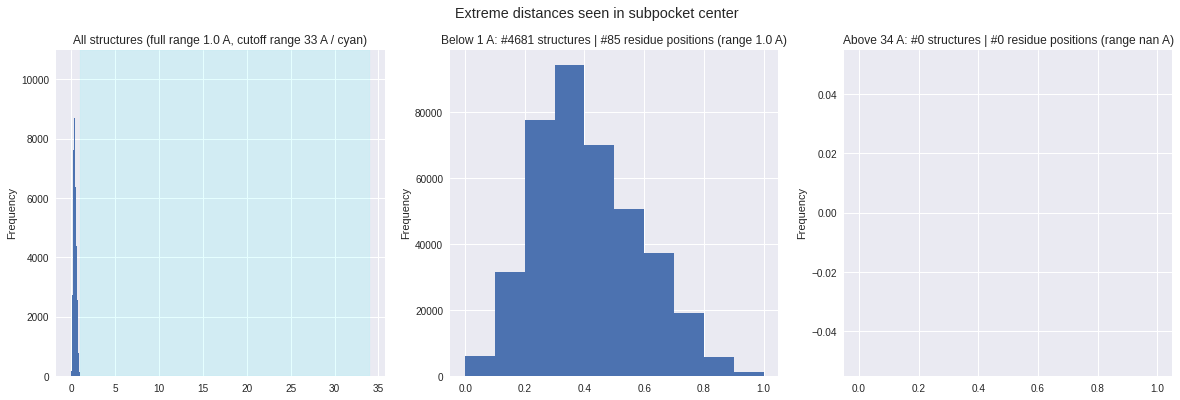

In [11]:
extreme_features = {}
for feature_type, _ in distances.items():
    features_min, features_max = extreme_distances(distances, feature_type, DISTANCE_CUTOFFS)
    extreme_features[feature_type] = (features_min, features_max)

__Note__: We will not define a minimum cutoff because it is possible that a subpocket center sits very closely to a residue CA atom and thus, in this case we would not speak of an outlier. In the following we will only focus on the long distances outliers.

### Pocket center

In [12]:
extreme_features["center"][1]

Series([], Name: center, dtype: float64)

In [13]:
extreme_features["center"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

### Front pocket

In [14]:
extreme_features["front_pocket"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

In [15]:
extreme_features["front_pocket"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[]

### Hinge region

In [16]:
extreme_features["hinge_region"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

In [17]:
extreme_features["hinge_region"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[]

### DFG region

In [18]:
extreme_features["dfg_region"][1].reset_index().groupby("residue_ix").size()

Series([], dtype: int64)

In [19]:
extreme_features["dfg_region"][1].index.get_level_values("structure_klifs_id").unique().to_list()

[]

## Look at structures with extremely long distances

In [20]:
extreme_structures_max = []
for subpocket_name, features in extreme_features.items():
    extreme_structures_max.extend(
        features[1].index.get_level_values("structure_klifs_id").unique()
    )
extreme_structures_max = set(extreme_structures_max)

print(f"Structures with extremly long distances: {extreme_structures_max}")

Structures with extremly long distances: set()
